In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Concatenate, Input, MaxPool2D, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import numpy as np

class DoodleSDQModel():
    def __init__(self, global_input_size, local_input_size, output_size):
        #super(DoodleSDQModel, self).__init__()
        self.global_input_size = global_input_size
        self.local_input_size = local_input_size
        self.output_size = output_size
        
        self.model = self._create_model()
        
        # class weight: down=1, up=0.5
        self.class_weight = {i:1 if i<121 else 0.5 for i in range(output_size)}
        
        
    def _create_model(self):
        local_input = tf.keras.Input(shape=self.local_input_size)
        global_input = tf.keras.Input(shape=self.global_input_size)
        
        inputs = [global_input, local_input]
        
        x_local = self._create_local_CNN(local_input)
        x_global = self._create_global_CNN(global_input)
        
        x = Concatenate(axis=1)([x_global, x_local])
        
        x = Dense(2048)(x)
        x = Dropout(.5)(x)
        x = Activation("relu")(x)
        x = Dense(self.output_size)(x)
        outputs = Activation("softmax") (x)
        return Model(inputs, outputs, name="doodle_dqn")

    def _create_global_CNN(self, input):
        
        x = Conv2D(32, (8,8), strides=(4,4), padding='same')(input)
        x = Activation("relu")(x)
        
        x = Conv2D(64, (4,4), strides=(2,2), padding='same')(x)
        x = Activation("relu")(x)
        
        x = Conv2D(64, (3,3), strides=(1,1), padding='same')(x)
        x = Activation("relu")(x)
        
        x = Flatten()(x)
        
        return x

    def _create_local_CNN(self, input):
        x = Conv2D(128, (11,11), padding='same')(input)
        x = Activation("relu")(x)
        
        x = Flatten()(x)
        return x
    
    def train(self,training_gen, validation_data, epochs, init_epoch=0):
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, verbose=1)
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1)
        tensorboard = TensorBoard(
                              log_dir='logs/layer2048-242-curr-2',
                              histogram_freq=0,
                              write_images=True
                            )
        
        self.epochs = epochs
        self.model.compile(optimizer=Adam(lr=.003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.history = self.model.fit(training_gen,\
                                      validation_data=validation_data, \
                                      validation_steps= len(validation_data),\
                                      epochs=epochs, \
                                      initial_epoch=init_epoch,\
                                      callbacks=[reduce_lr, tensorboard], \
#                                       class_weight=self.class_weight, \
                                      verbose=1)
    
    def plot(self):
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']

        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        epochs_range = range(self.epochs)

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()
#     def _create_dense(self):
#         input_shape = (None, self.model_global.output_shape[1] + self.model_local.output_shape[1])
#         model = Sequential()
#         model.add(Input(shape=input_shape))
#         model.add(Dense(256, activation="relu"))
#         model.add(Dense(self.output_size, activation="softmax"))
#         return model

#     def call(self, inputs, patches):
#         print("call")
#         global_input = inputs
#         local_input = patches
#         global_features = self.model_global(global_input)
#         local_features = self.model_local(local_input)
        
#         x = Concatenate(axis=1)([global_features, local_features])
#         y_pred = self.dense(x)
        
#         return y_pred


In [2]:
from random_stroke_generator import RandomStrokeGenerator

In [3]:
training_gen = RandomStrokeGenerator(batch_size=484,num_data=4840, min_strokes=4, max_strokes=64)
valid_gen = RandomStrokeGenerator(batch_size=242, num_data=968, min_strokes=4, max_strokes=64)

In [4]:
global_size = (84,84,4)
local_size = (11,11,2)
model1 = DoodleSDQModel(global_input_size=global_size, local_input_size=local_size, output_size=242)
model_base = DoodleSDQModel(global_input_size=global_size, local_input_size=local_size, output_size=121)


In [ ]:
model1.model.summary()

In [ ]:
from tensorflow import keras

keras.utils.plot_model(model1.model, "doodle_sdq.png", show_shapes=True)

In [5]:
model1.train(training_gen, valid_gen, 150, init_epoch=0)

Epoch 1/150
10/10 [==============================] - 1s 91ms/step - loss: 6.3614 - accuracy: 0.0079 - val_loss: 5.4888 - val_accuracy: 0.0041 - lr: 0.0030
Epoch 2/150
10/10 [==============================] - 1s 67ms/step - loss: 5.4872 - accuracy: 0.0081 - val_loss: 5.4830 - val_accuracy: 0.0072 - lr: 0.0030
Epoch 3/150
10/10 [==============================] - 1s 72ms/step - loss: 5.4641 - accuracy: 0.0132 - val_loss: 5.3960 - val_accuracy: 0.0227 - lr: 0.0030
Epoch 4/150
10/10 [==============================] - 1s 66ms/step - loss: 5.1641 - accuracy: 0.0492 - val_loss: 4.6185 - val_accuracy: 0.1157 - lr: 0.0030
Epoch 5/150
10/10 [==============================] - 1s 65ms/step - loss: 4.2378 - accuracy: 0.1295 - val_loss: 3.7815 - val_accuracy: 0.2045 - lr: 0.0030
Epoch 6/150
10/10 [==============================] - 1s 65ms/step - loss: 3.6966 - accuracy: 0.2180 - val_loss: 3.4057 - val_accuracy: 0.3027 - lr: 0.0030
Epoch 7/150
10/10 [==============================] - 1s 65ms/step - lo

Epoch 49/150
 9/10 [==========================>...] - ETA: 0s - loss: 3.0680 - accuracy: 0.4050
Epoch 00049: ReduceLROnPlateau reducing learning rate to 7.289999848580919e-06.
10/10 [==============================] - 1s 68ms/step - loss: 3.0677 - accuracy: 0.4052 - val_loss: 2.7948 - val_accuracy: 0.4463 - lr: 2.4300e-05
Epoch 50/150
10/10 [==============================] - 1s 67ms/step - loss: 3.0225 - accuracy: 0.4085 - val_loss: 2.6475 - val_accuracy: 0.4721 - lr: 7.2900e-06
Epoch 51/150
10/10 [==============================] - 1s 68ms/step - loss: 3.0176 - accuracy: 0.4167 - val_loss: 3.0501 - val_accuracy: 0.4091 - lr: 7.2900e-06
Epoch 52/150
10/10 [==============================] - 1s 68ms/step - loss: 3.1052 - accuracy: 0.3998 - val_loss: 3.0561 - val_accuracy: 0.4101 - lr: 7.2900e-06
Epoch 53/150
10/10 [==============================] - 1s 67ms/step - loss: 3.1324 - accuracy: 0.3880 - val_loss: 2.9351 - val_accuracy: 0.4256 - lr: 7.2900e-06
Epoch 54/150
10/10 [=================

10/10 [==============================] - 1s 68ms/step - loss: 3.2357 - accuracy: 0.3667 - val_loss: 2.8665 - val_accuracy: 0.4339 - lr: 5.3144e-09
Epoch 94/150
10/10 [==============================] - 1s 70ms/step - loss: 3.3247 - accuracy: 0.3632 - val_loss: 2.9699 - val_accuracy: 0.4101 - lr: 5.3144e-09
Epoch 95/150
10/10 [==============================] - 1s 68ms/step - loss: 3.3329 - accuracy: 0.3537 - val_loss: 3.0665 - val_accuracy: 0.3926 - lr: 5.3144e-09
Epoch 96/150
10/10 [==============================] - 1s 66ms/step - loss: 3.2956 - accuracy: 0.3560 - val_loss: 3.1319 - val_accuracy: 0.3709 - lr: 5.3144e-09
Epoch 97/150
10/10 [==============================] - 1s 69ms/step - loss: 3.1652 - accuracy: 0.3829 - val_loss: 3.0794 - val_accuracy: 0.3884 - lr: 5.3144e-09
Epoch 98/150
10/10 [==============================] - 1s 67ms/step - loss: 3.3200 - accuracy: 0.3556 - val_loss: 3.1614 - val_accuracy: 0.3915 - lr: 5.3144e-09
Epoch 99/150
 9/10 [==========================>...] -

Epoch 138/150
10/10 [==============================] - 1s 71ms/step - loss: 3.3277 - accuracy: 0.3486 - val_loss: 3.2439 - val_accuracy: 0.3812 - lr: 3.8742e-12
Epoch 139/150
10/10 [==============================] - 1s 65ms/step - loss: 3.4200 - accuracy: 0.3413 - val_loss: 3.2497 - val_accuracy: 0.3585 - lr: 3.8742e-12
Epoch 140/150
10/10 [==============================] - 1s 65ms/step - loss: 3.4337 - accuracy: 0.3333 - val_loss: 3.1917 - val_accuracy: 0.3729 - lr: 3.8742e-12
Epoch 141/150
 9/10 [==========================>...] - ETA: 0s - loss: 3.3744 - accuracy: 0.3418
Epoch 00141: ReduceLROnPlateau reducing learning rate to 1.1622613028255957e-12.
10/10 [==============================] - 1s 67ms/step - loss: 3.3576 - accuracy: 0.3440 - val_loss: 3.2397 - val_accuracy: 0.3481 - lr: 3.8742e-12
Epoch 142/150
10/10 [==============================] - 1s 63ms/step - loss: 3.3463 - accuracy: 0.3426 - val_loss: 3.1794 - val_accuracy: 0.3833 - lr: 1.1623e-12
Epoch 143/150
10/10 [==========

In [6]:
! tensorboard --logdir "logs/layer2048-242-curr-2/"

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.3.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [ ]:
X, y = training_gen.__getitem__(1)

In [ ]:
model1.model.evaluate(training_gen)

In [ ]:
model1.model.evaluate(valid_gen)

In [ ]:
pred = model1.model.predict(X)
print(pred)

In [ ]:
print(y)

In [ ]:
import numpy as np
y_pred = np.argmax(pred, axis=1)
print(y_pred[y_pred!=y])

In [ ]:
X2, y2 = valid_gen.__getitem__(1)

pred2 = model1.model(X2)

print(np.argmax(pred2, axis=1)==y2)

In [ ]:
import numpy as np
a = X[0][0,:,:,2]
ind = np.unravel_index(np.argmin(a), a.shape)
print(ind)


In [ ]:
print(84*84)

In [ ]:
from drawing_env import Drawer
import numpy as np

drawer = Drawer()
def draw_action(canvas, distance_map, action):
    drawer.set_canvas(canvas)
    pen_pos = np.unravel_index(np.argmin(distance_map), distance_map.shape)
    drawer.set_pen_position((pen_pos[1], pen_pos[0]))
    drawer.do_action(action)
    return np.copy(drawer.get_canvas())



In [ ]:
import matplotlib.pyplot as plt

X,y = training_gen.__getitem__(1)
pred = model_base.model.predict(X)
y_pred = np.argmax(pred, axis=1)

# Plot
fig=plt.figure(figsize=(12, 64))
cols = 6
rows = 24

for i in range(12):
    canvas = X[0][i,:,:,1]
    distance_map = X[0][i,:,:,2]
    action = y[i]
    action_pred = y_pred[i]
    canv_truth = draw_action(canvas, distance_map, action)
    canv_pred = draw_action(canvas, distance_map, action_pred)
    fig.add_subplot(rows, cols, 3*i+1)
    plt.imshow(canv_truth)
    fig.add_subplot(rows, cols, 3*i+2)
    plt.imshow(canv_pred)
    
    fig.add_subplot(rows, cols, 3*i+3)
    plt.imshow(distance_map)
    
plt.show()
    

In [ ]:
import matplotlib.pyplot as plt
print("--- After training")
X,y = training_gen.__getitem__(0)
pred = model1.model.predict(X)
y_pred = np.argmax(pred, axis=1)

# Plot
fig=plt.figure(figsize=(16, 64))
cols = 8
rows = 24

for i in range(12):
    ref = X[0][i,:,:,0]
    canvas = X[0][i,:,:,0]
    distance_map = X[0][i,:,:,2]
    action = y[i]
    action_pred = y_pred[i]
    canv_truth = draw_action(canvas, distance_map, action)
    canv_pred = draw_action(canvas, distance_map, action_pred)
    fig.add_subplot(rows, cols, 4*i+1)
    plt.imshow(canv_truth)
    fig.add_subplot(rows, cols, 4*i+2)
    plt.imshow(canv_pred, cmap='gray')
    
    fig.add_subplot(rows, cols, 4*i+3)
    plt.imshow(distance_map, cmap='gray')
    
    fig.add_subplot(rows, cols, 4*i+4)
    plt.imshow(ref, cmap='gray')
    
plt.show()

In [16]:
from drawing_env import Drawer
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_test(drawer, strokes=32):
    actions = np.random.randint(0, 242, strokes)
    for action in actions:
        drawer.do_action(action)
        
    return drawer.get_canvas()

def get_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (84,84))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = 1-(img / 255)
    print(img)
    img = np.array(img, dtype=np.float)
    print(img.shape, type(img), img.dtype)
    return img

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(84, 84) <class 'numpy.ndarray'> float64


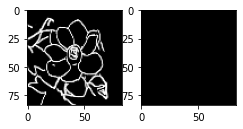

In [27]:
from copy import deepcopy

drawer_test = Drawer()
drawer_test.reset()
drawer_test.set_pen_position((40,40))
strokes = 500

drawer_ref = deepcopy(drawer_test)
# Test using random stroke
# ref = generate_test(drawer_ref, strokes)

# Test using image
ref = get_image('../Sketch/PhotoSketch/Exp/PhotoSketch/Results/International_Flower_Day_1200x1200.png')
drawer_ref.set_canvas(ref)


fig=plt.figure(figsize=(16, 8))
cols = 8
rows = 1
fig.add_subplot(rows, cols, 1)
plt.imshow(ref, cmap='gray')
fig.add_subplot(rows, cols, 2)
plt.imshow(drawer_test.get_canvas(), cmap='gray')

plt.show()
canvas = []

for i in range(strokes):
    # Prepare X
    dis = drawer_test.get_distance_map()
    col = drawer_test.get_color_map()
    cp = drawer_test.get_patch()
    rp = drawer_ref.get_patch(drawer_test.get_pen_position())
    x = np.stack( (ref, drawer_test.get_canvas(), dis, col), axis=2)
    p = np.stack( (cp, rp), axis=2)
    
    x = np.expand_dims(x, axis=0)
    p = np.expand_dims(p, axis=0)
    
    pred = model.predict([x,p])
    action = np.argmax(pred)
    drawer_test.do_action(action)
    canvas.append(drawer_test.get_canvas())


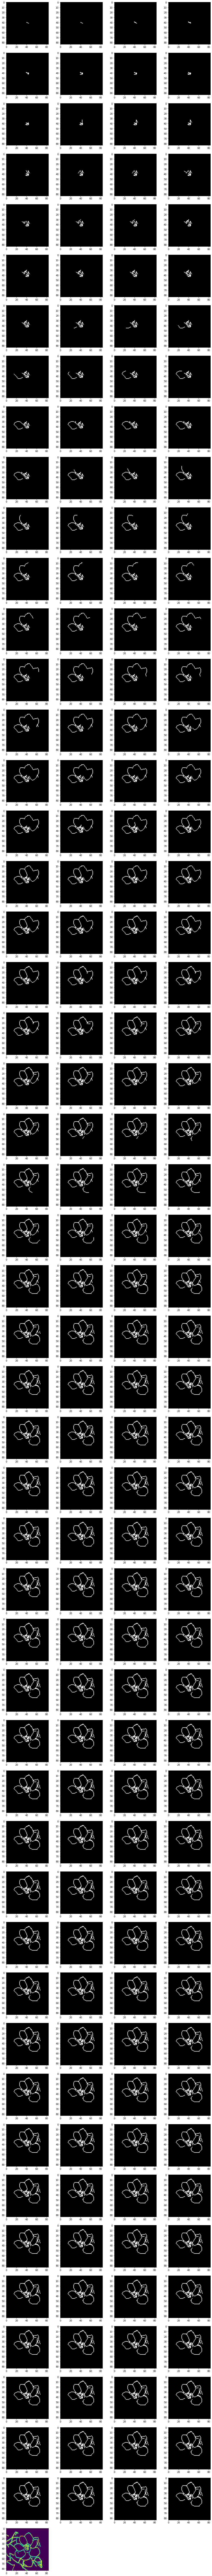

In [25]:
cols = 4
rows = strokes//cols + 1
fig=plt.figure(figsize=(4*cols, 4*rows))

for i in range(strokes):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(canvas[i], cmap='gray')
fig.add_subplot(rows, cols, strokes+1)
plt.imshow(ref)
plt.show()

In [28]:
import cv2
import numpy as np
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('test_out_bunga.avi',fourcc, 20.0, (84*2,84*1))
for i in range(strokes):
    images = (np.hstack((ref, canvas[i]))*255).astype("uint8")
    images = cv2.cvtColor(images, cv2.COLOR_GRAY2BGR)

#     cv2.imshow("Video", images)
#     cv2.imshow("patch", new_observation[4])
    out.write(images)

out.release()

In [13]:
model1.model.save('model/curr-2.h5')

In [14]:
model = tf.keras.models.load_model('model/curr-2.h5')

In [15]:
model.summary()

Model: "doodle_dqn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 84, 84, 4)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 21, 21, 32)   8224        input_2[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 21, 21, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 11, 11, 64)   32832       activation_1[0][0]               
_________________________________________________________________________________________